# Modeling the result of a radio astronomy observation

This notebook uses the Python modules to model the resulting power
levels seen by a radio telescope - the Westford antenna - when observing an
astronomical object such as Cas A.

In [ ]:
import sy
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Add the parent directory (which contains src/) to the path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

from radio_types import Antenna, Instrument, Observation, Constellation, Trajectory
from astro_mdl import (
    estim_casA_flux, power_to_temperature, temperature_to_power,
    antenna_mdl_ITU, estim_temp
)
from sat_mdl import sat_link_budget_vectorized
from obs_mdl import model_observed_temp
import antenna_pattern

## Define the instrument used to observe
---

### The antenna

The first step to define the instrument of observation is to define the antenna
used. The package has a custom structure `Antenna` that takes as inputs a
`DataFrame` structure with columns `alphas`, `betas` and `gains`, containing
the gain values and their angle coordinates ($\alpha$,$\beta$), the estimated
radiation efficiency and the frequency band where the model of antenna defined
is valid. $\alpha\in[0,180]$ and $\beta\in[0,360[$ are defined such that when
the antenna is pointing at the horizon, $\beta=0$ gives a vertical slice of the
pattern, with $\alpha>0$ oriented towards the ground.

A path to a `.cut` file defining the power pattern model can be given in place
of the `DataFrame` structure to load and format the gain pattern. In that case,
it is possible to give the tags of the different columns if other names are
present in the table to load.

In [2]:
# radiation efficiency of telescope antenna
eta_rad = 0.45

# valid frequency band of gain pattern model
freq_band = (10e9, 12e9)  # in Hz

# Get the directory where this script is located
script_dir = os.getcwd()

# load telescope antenna
file_pattern_path = os.path.join(script_dir, "data", "single_cut_res.cut")
tel_ant = Antenna.from_file(
    file_pattern_path,
    eta_rad,
    freq_band,
    power_tag='power',
    declination_tag='alpha',
    azimuth_tag='beta'
)

This power_pattern_from_cut_file function assumes Daniel Sheen generated files


The result is an `Antenna` storing the different information and an interpolated
version of the gain pattern.

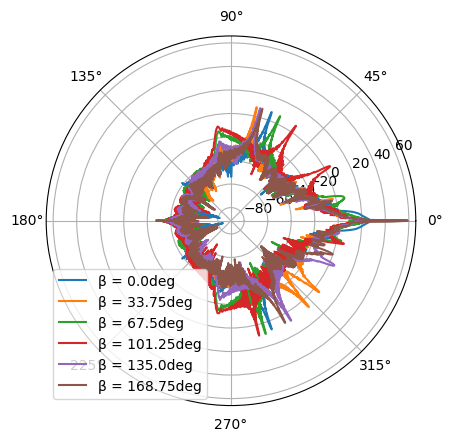

In [3]:
# plot gain pattern
nb_curv = 5  # number of slices to plot
alphas, betas = tel_ant.get_def_angles()
step_beta_ind = len(betas) // (2 * nb_curv)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i in range(0, len(betas) // 2, step_beta_ind):
    a, g = tel_ant.get_slice_gain(betas[i])
    ax.plot(np.radians(a), 10 * np.log10(g), label=f"β = {betas[i]}deg")
ax.legend()
plt.show()

### The instrument

To define the `Instrument` of observation as a structure, we need an `Antenna`
structure, as well as other parameters:
- the physical temperature of the antenna;
- the frequency of observation;
- the bandwidth of the instrument;
- the receiver temperature as a function of time (`datetime` type) and frequency;
It is also possible to specify:
- the number of frequency channels to divide the bandwidth of the instrument by
  (default is 1);
- the coordinates of the instrument as a vector (not used as of now);

In [4]:
# telescope antenna physical temperature
T_phy = 300.0  # in K

# frequency of observation
cent_freq = 11.325e9  # in Hz

# bandwidth of telescope receiver
bw = 1e3  # in Hz

# number of frequency channels to divide the bandwidth
freq_chan = 1

# telescope receiver temperature (constant over the bandwidth)
def T_RX(tim, freq):
    return 80.0  # in K

# coordinates of telescope
coords = [42.6129479883915, -71.49379366344017, 86.7689687917009]

# create instrument
westford = Instrument(tel_ant, T_phy, cent_freq, bw, T_RX, freq_chan, coords)

## Define the observation plan
---

The next step is to define the observation plan and conditions.

### The pointing trajectory during the observation

It is possible to load an already computed table of pointing directions. For
instance, an `.arrow` file containing the position of Cas A over a window of
time. The package defines a `Trajectory` structure that formats a `DataFrame` to
be used thereafter.

`Trajectory` can receive the path to an `.arrow` or `.csv` file instead of the
`DataFrame` to load an existing file. In that case, it is possible to give the
tags of the different columns if other names are present in the table to load.

In [5]:
# time window of generated source trajectory
start_window = "2025-02-18T15:00:00.000"
stop_window = "2025-02-18T15:45:00.000"

# replace colon with underscore
start_window_str = start_window.replace(":", "_")
stop_window_str = stop_window.replace(":", "_")

# load telescope antenna
file_traj_obj_path = os.path.join(script_dir, "data", f"casA_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow")

print(file_traj_obj_path)

# source position over time window
traj_src = Trajectory.from_file(
    file_traj_obj_path,
    time_tag='time_stamps',
    elevation_tag='altitudes',
    azimuth_tag='azimuths',
    distance_tag='distances'
)

c:\NatHaz\DK\CRC\SpectrumX\cursor_test\RadioMdlPy\tutorial\data\casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow


To be more realistic, say the observation lasted 10min, with 5min offset and
5min on source, excluding any points that could be below 5deg elevation:

In [6]:
# start-end of observation
dateformat = "%Y-%m-%dT%H:%M:%S.%f"
start_obs = datetime.strptime("2025-02-18T15:30:00.000", dateformat)
stop_obs = datetime.strptime("2025-02-18T15:40:00.000", dateformat)

# offset from source at the beginning of the observation
offset_angles = (-40, 0.)  # (az,el) in degrees

# time of OFF-ON transition
time_off_src = start_obs
time_on_src = time_off_src + timedelta(minutes=5)

# copy trajectory
traj_obj = Trajectory(traj_src.traj.copy())

# apply offset
mask = (traj_obj.traj['times'] >= time_off_src) & (traj_obj.traj['times'] <= time_on_src)
traj_obj.traj.loc[mask, 'azimuths'] += offset_angles[0]
traj_obj.traj.loc[mask, 'elevations'] += offset_angles[1]

# filter points below 5deg elevation
filt_el = ('elevations', lambda e: e > 5.)

# create observation
observ = Observation.from_dates(start_obs, stop_obs, traj_obj, westford, filt_funcs=(filt_el,))


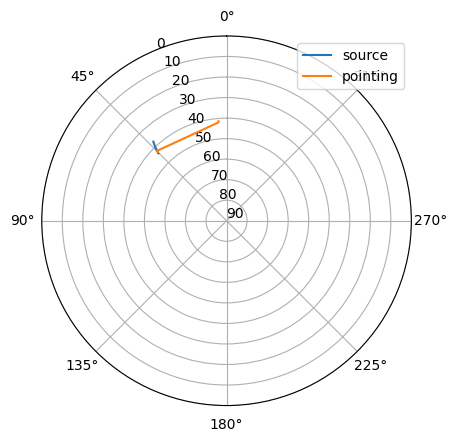

In [7]:
# visualize source and pointing trajectory
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, polar=True)
src_traj = traj_src.get_traj()
obs_traj = observ.get_traj()
ax.plot(np.radians(src_traj['azimuths']), 90 - src_traj['elevations'], label="source")
ax.plot(np.radians(obs_traj['azimuths']), 90 - obs_traj['elevations'], label="pointing")
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.legend()
ax.set_theta_zero_location("N")
plt.show()

### Sky model

Accounting for the sky components is important to have a realistic simulation of
the power received.

Given the fact that we will point at Cas A for a part of the observation, we
need to account for the difference of temperature depending on the pointing position:

In [8]:
# source flux
flux_src = estim_casA_flux(cent_freq)  # in Jy

# Pre-calculate effective aperture for performance optimization
max_gain = tel_ant.get_boresight_gain()
A_eff_max = antenna_pattern.gain_to_effective_aperture(max_gain, cent_freq)

# source temperature in K
def T_src(t):
    if t <= time_on_src:
        return 0.0
    else:
        return estim_temp(flux_src, A_eff_max)

Same for the RFI and the background sources that can be modeled as constants as a first approximation:

In [9]:
# ground temperature in K
T_gnd = 0  # no constant RFI

# various RFI
T_var = 0  # in K (no RFI)

# total RFI temperature
T_rfi = T_gnd + T_var

# CMB temperature
T_CMB = 2.73  # in K

# galaxy temperature
def T_gal(freq): return 1e-1 * (freq/1.41e9)**(-2.7)  # in K

# background
def T_bkg(freq): return T_CMB + T_gal(freq)

The atmosphere is also important to account for:

In [10]:
# atmospheric temperature at zenith
T_atm_zenith = 150  # in K

# opacity of atmosphere at zenith
tau = 0.05

# atmospheric temperature model
def T_atm(dec): return T_atm_zenith * (1 - np.exp(-tau/np.cos(dec)))  # in K

Adding up all of these sources gives:

In [11]:
# Total sky model in K
def sky_mdl(dec, caz, tim, freq):
    return T_src(tim) + T_atm(dec) + T_rfi + T_bkg(freq)

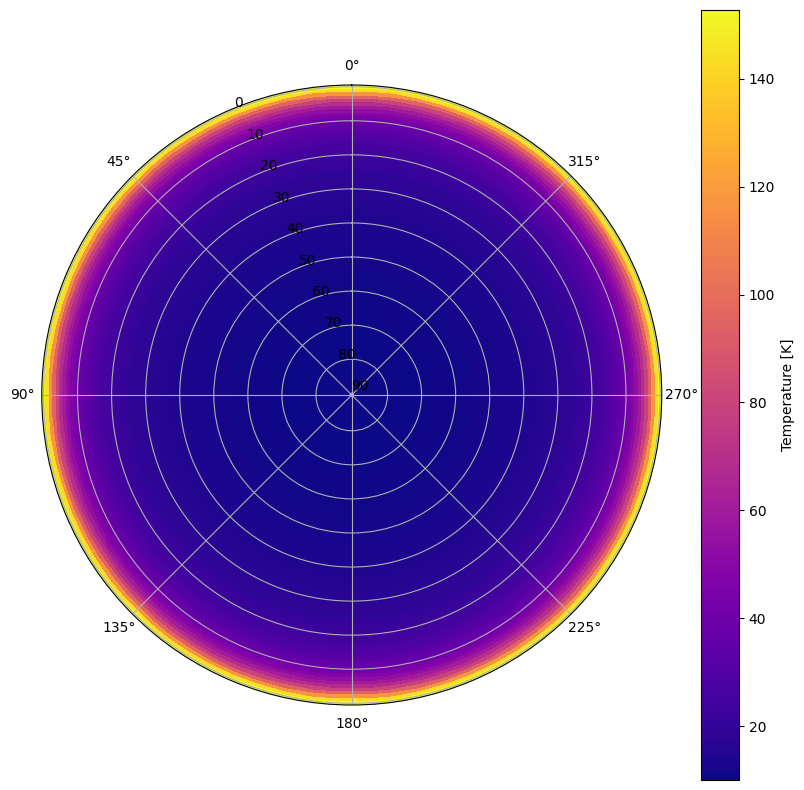

In [12]:
# plot of sky model without source
azimuth_grid = np.arange(0, 361, 5)
elevation_grid = np.arange(0, 91, 1)
az_grid, el_grid = np.meshgrid(azimuth_grid, elevation_grid)
sky_temp = np.vectorize(lambda el, az: sky_mdl(np.radians(90-el), -np.radians(az), start_obs, cent_freq))(el_grid, az_grid)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, polar=True)
pc = ax.pcolormesh(np.radians(azimuth_grid), 90-elevation_grid, sky_temp, cmap="plasma")
cbar = plt.colorbar(pc)
cbar.set_label("Temperature [K]")
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.set_theta_zero_location("N")
plt.show()

## Satellite constellations
--- 
The package also defines a structure `Constellation` to account for aggregated
power from satellites.

### Antenna model

The first step is to define the antenna model for the type of satellites in the
constellation, as for instance the ITU recommended gain model.

Note that in the following, the satellites coordinate frame is supposed to be
following (North, East, Nadir).

In [13]:
# radiation efficiency of telescope antenna
sat_eta_rad = 0.5  # FIXME: check value

# maximum gain of satellite antenna
sat_gain_max = 39.3  # in dBi FIXME: check value in dBi

# create ITU recommended gain profile
# satellite boresight half beamwidth
half_beamwidth = 3.0  # in deg FIXME: check value
# declination angles alpha
alphas = np.arange(0, 181)
# azimuth angles beta
betas = np.arange(0, 351, 10)
# create gain dataframe
gain_pat = antenna_mdl_ITU(sat_gain_max, half_beamwidth, alphas, betas)

# create satellite antenna
sat_ant = Antenna.from_dataframe(gain_pat, sat_eta_rad, freq_band)

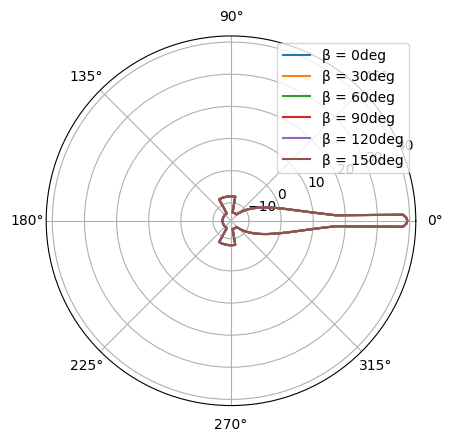

In [14]:
# plot gain pattern
nb_curv = 5  # number of slices to plot
alphas, betas = sat_ant.get_def_angles()
step_beta_ind = len(betas) // (2 * nb_curv)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i in range(0, len(betas) // 2, step_beta_ind):
    a, g = sat_ant.get_slice_gain(betas[i])
    ax.plot(np.radians(a), 10 * np.log10(g), label=f"β = {betas[i]}deg")
ax.legend()
plt.show()

### Transmitter parameters

The satellites are transmitting information and can be defined as an
`Instrument` structure:

In [15]:
# telescope antenna physical temperature
sat_T_phy = 0.0  # in K

# frequency of transmission
sat_freq = 11.325e9  # in Hz

# satellite transmission bandwidth
sat_bw = 250e6  # in Hz

# satellite effective isotropically radiated power
transmit_pow = -15 + 10 * np.log10(300)  # in dBW FIXME: check value
def transmit_temp(tim, freq):
    return power_to_temperature(10**(transmit_pow/10), 1.0)  # in K

# create transmitter instrument
sat_transmit = Instrument(sat_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp, 1, [])

### Constellation

Taking a pre-generated file containing the trajectory of each satellite at each
time samples of the observation. The `Constellation` structure takes as input
the path to this file, the `Observation` structure and the `Instrument` with which
the satellites are transmitting.

The structure can take the tags of the columns of the table and additional
filters:

In [16]:
# filter the satellites
filt_name = ('sat', lambda s: ~s.str.contains('DTC'))
filt_el = ('elevations', lambda e: e > 20)

# satellite link budget estimator
def lnk_bdgt(*args, **kwargs):
    # "Catch" the unexpected argument and remove it from the dictionary.
    # The second argument to pop (e.g., None) is a default value if 'beam_avoid' isn't present.
    beam_avoid_angle = kwargs.pop('beam_avoid', None)

    # Now you can use the value of beam_avoid_angle for any custom logic
    # within this wrapper function if you need to.
    if beam_avoid_angle is not None:
        # For example: print(f"Beam avoidance angle is {beam_avoid_angle} degrees.")
        # Or you could modify one of the *args based on this value before passing them on.
        pass

    # Call the base function with only the arguments it actually expects.
    # `kwargs` no longer contains the 'beam_avoid' key.
    return sat_link_budget_vectorized(*args, **kwargs)

# satellites trajectories during the observation
file_traj_sats_path = os.path.join(script_dir, "data", f"Starlink_trajectory_Westford_{start_window_str}_{stop_window_str}.arrow")

starlink_constellation = Constellation.from_file(
    file_traj_sats_path, observ, sat_transmit, lnk_bdgt,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(filt_name, filt_el)
)

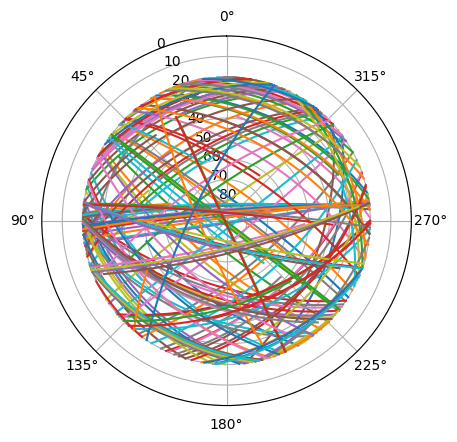

In [17]:
# plot satellites trajectory
list_sats = starlink_constellation.get_sats_name()

sel_sats = list_sats[:len(list_sats)]

for s in sel_sats:
    sat = starlink_constellation.get_sat_traj(s)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, polar=True)
for s in sel_sats:
    sat = starlink_constellation.get_sat_traj(s)
    ax.plot(np.radians(sat['azimuths']), 90 - sat['elevations'])
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.set_theta_zero_location("N")
plt.show()

## Model total power received during observation
---

The `model_observed_temp` takes as input the `Observation` and can also take a
`sky_mdl` function and one or a vector of `Constellation`. 

In [18]:
result = model_observed_temp(observ, sky_mdl, starlink_constellation)

The method also have a keyword `beam_avoid` that takes an angle value. If the
angle between the boresight of a satellite and the telescope pointing direction
is below this angle, the satellite "steers" away of 45deg.

In [19]:
obs_beam_avoid = Observation.from_dates(start_obs, stop_obs, traj_obj, westford)

def lnk_bdgt_beam_avoid(*args, **kwargs):
    return sat_link_budget_vectorized(*args, beam_avoid=10.0, turn_off=False, **kwargs)

starlink_const_beam_avoid = Constellation.from_file(
    file_traj_sats_path, observ, sat_transmit, lnk_bdgt_beam_avoid,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(filt_name, filt_el)
)

# Use the integrated model_observed_temp function with beam_avoidance=True
result_beam_avoid = model_observed_temp(obs_beam_avoid, sky_mdl, starlink_const_beam_avoid, beam_avoidance=True)

Without a satellite constellation:

In [20]:
obs_src = Observation.from_dates(start_obs, stop_obs, traj_obj, westford)

result_src = model_observed_temp(obs_src, sky_mdl)

With a constellation of satellites that are omni-directional and low power:

In [21]:
# create constant gain profile
# declination angles alpha
alphas = np.arange(0, 181)
# azimuth angles beta
betas = np.arange(0, 351, 10)
# minimum gain from sats
sat_gain_min = sat_ant.gain_pat['gains'].min()
# create gain dataframe
gain_pat = pd.DataFrame({
    'alphas': np.repeat(alphas, len(betas)),
    'betas': np.tile(betas, len(alphas)),
    'gains': np.full(len(alphas) * len(betas), sat_gain_min)
})
sat_cst_gain_ant = Antenna.from_dataframe(gain_pat, sat_eta_rad, freq_band)
sat_cst_gain_transmit = Instrument(sat_cst_gain_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp, 1, [])
starlink_cst_gain_constellation = Constellation.from_file(
    file_traj_sats_path, observ, sat_cst_gain_transmit, lnk_bdgt,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(filt_name, filt_el)
)

obs_cst_sat_gain = Observation.from_dates(start_obs, stop_obs, traj_obj, westford)

result_cst_sat_gain = model_observed_temp(obs_cst_sat_gain, sky_mdl, starlink_cst_gain_constellation)

### Visualization

Visualizing the different results as total power over time:

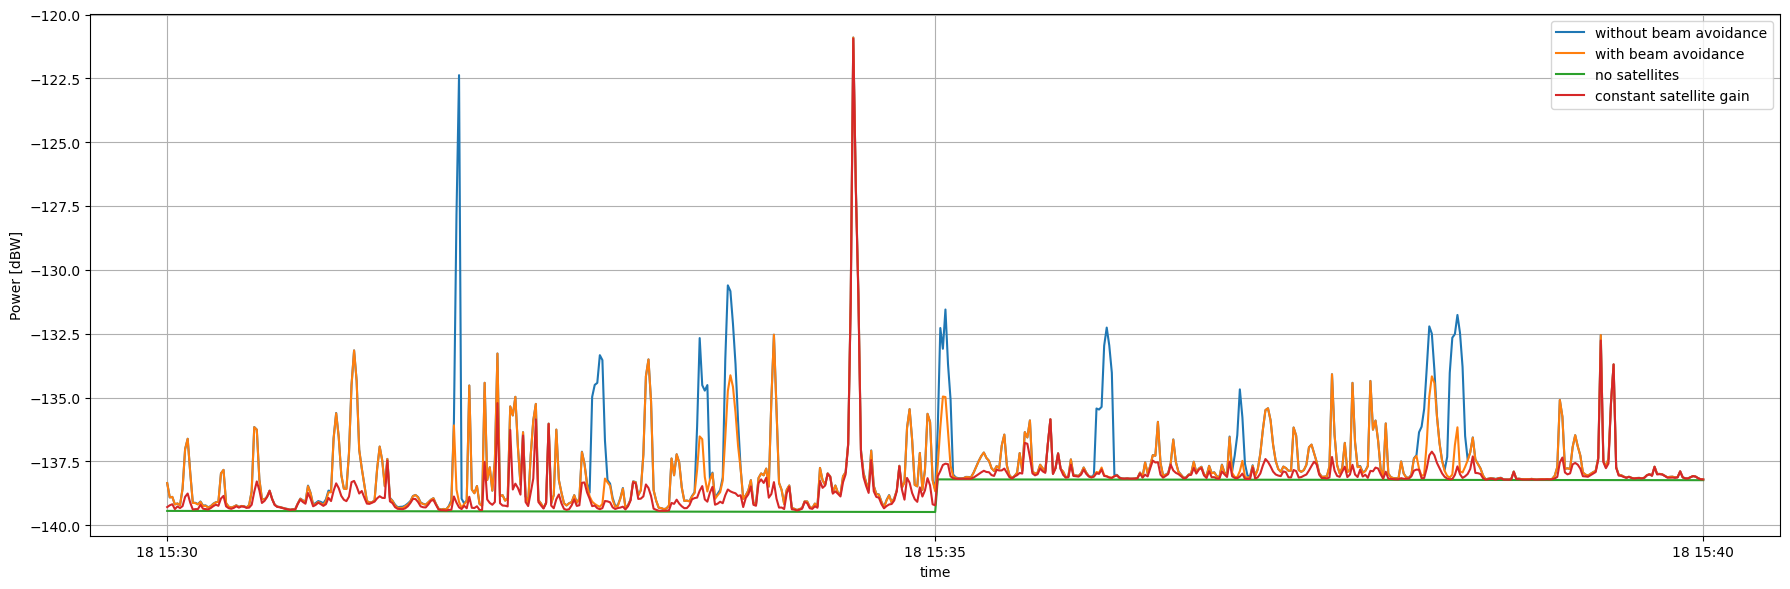

In [22]:
# prevent log10 of negative values
def safe_log10(x):
    x = np.array(x)
    x = np.where(x > 0, x, np.nan)
    return np.log10(x)

fig, ax = plt.subplots(figsize=(18, 6))
time_samples = observ.get_time_stamps()

# Observation without beam avoidance
plot_result = temperature_to_power(result[:, 0, 0], bw)
ax.plot(time_samples, 10 * safe_log10(plot_result), label="without beam avoidance")

# Observation with beam avoidance
plot_result = temperature_to_power(result_beam_avoid[:, 0, 0], bw)
ax.plot(time_samples, 10 * safe_log10(plot_result), label="with beam avoidance")

# Observation without constellation
plot_result = temperature_to_power(result_src[:, 0, 0], bw)
ax.plot(time_samples, 10 * safe_log10(plot_result), label="no satellites")

# Observation with constellation of constant gain
plot_result = temperature_to_power(result_cst_sat_gain[:, 0, 0], bw)
ax.plot(time_samples, 10 * safe_log10(plot_result), label="constant satellite gain")

ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("Power [dBW]")
ax.grid(True)
fig.tight_layout()
plt.show()

Focusing on a specific time to see where the satellites are located compare to
the pointing direction of the telescope:

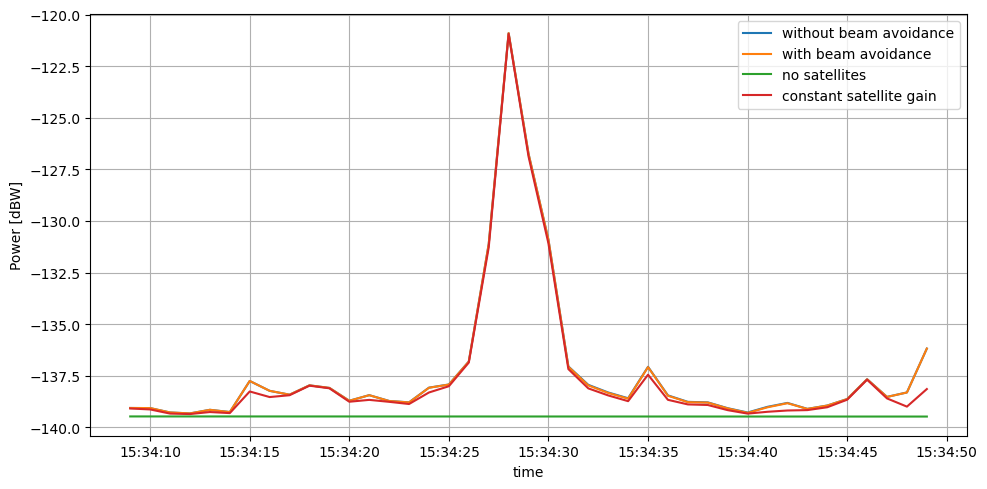

In [23]:
# zoom dates
start_zoom = datetime.strptime("2025-02-18T15:34:09.000", dateformat)
stop_zoom = datetime.strptime("2025-02-18T15:34:49.000", dateformat)
time_samples = observ.get_time_stamps()
time_zoom = time_samples[(time_samples >= start_zoom) & (time_samples <= stop_zoom)]

fig, ax = plt.subplots(figsize=(10, 5))
# Observation without beam avoidance
zoom_indices = [i for i, t in enumerate(time_samples) if start_zoom <= t <= stop_zoom]
plot_result = temperature_to_power(result[zoom_indices, 0, 0], bw)
ax.plot(time_zoom, 10 * np.log10(plot_result), label="without beam avoidance")
# Observation with beam avoidance
plot_result = temperature_to_power(result_beam_avoid[zoom_indices, 0, 0], bw)
ax.plot(time_zoom, 10 * np.log10(plot_result), label="with beam avoidance")
# Observation without constellation
plot_result = temperature_to_power(result_src[zoom_indices, 0, 0], bw)
ax.plot(time_zoom, 10 * np.log10(plot_result), label="no satellites")
# Observation with constellation of constant gain
plot_result = temperature_to_power(result_cst_sat_gain[zoom_indices, 0, 0], bw)
ax.plot(time_zoom, 10 * np.log10(plot_result), label="constant satellite gain")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("Power [dBW]")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

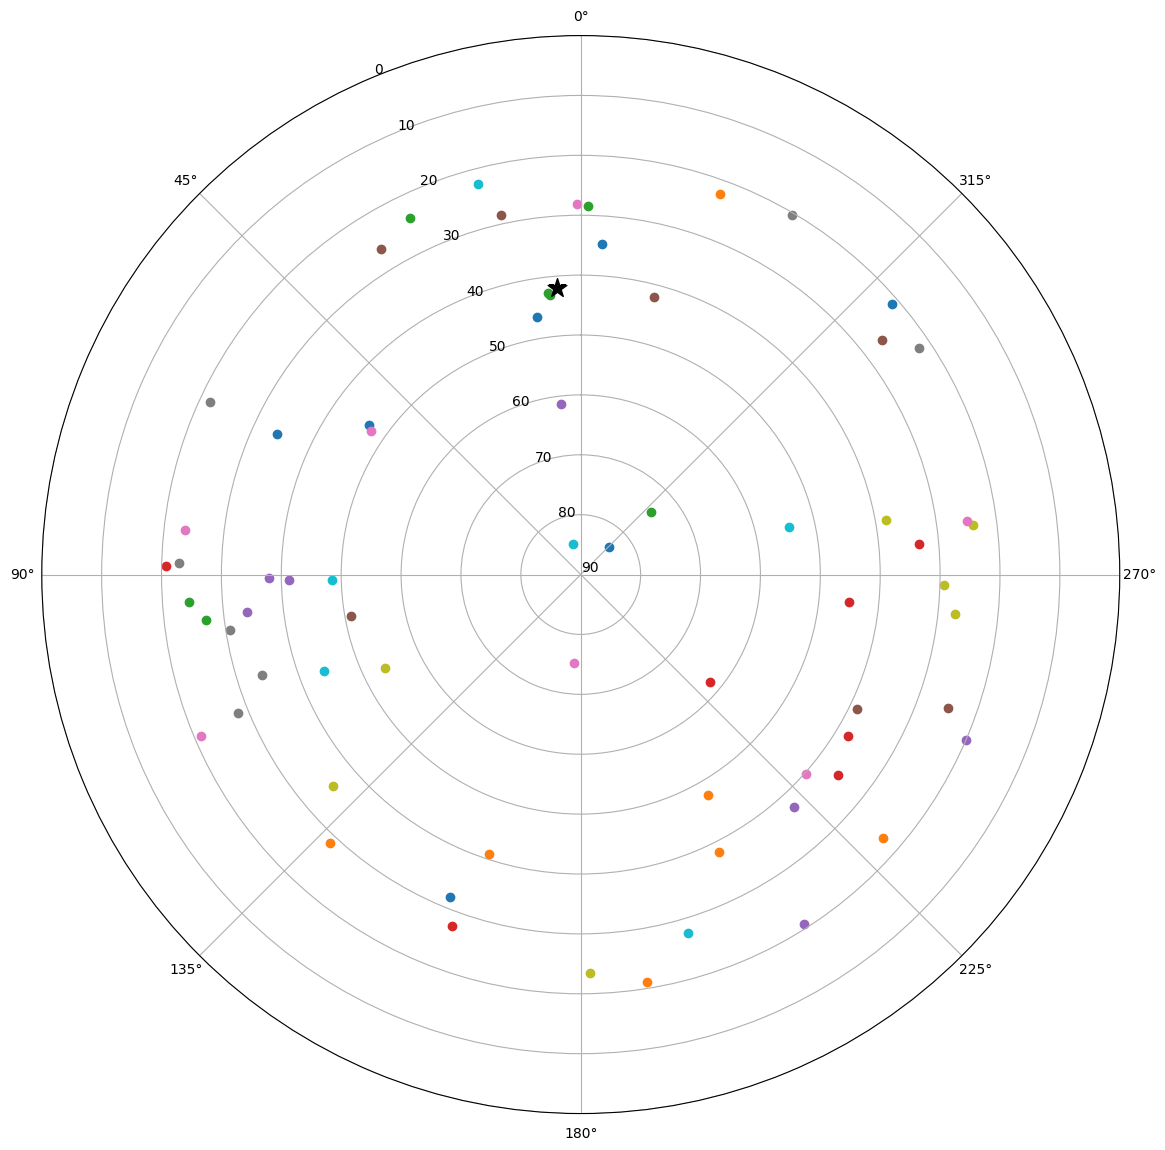

In [24]:
time_study = datetime.strptime("2025-02-18T15:34:29.000", dateformat)
sats_at_t = starlink_constellation.get_sats_names_at_time(time_study)

sel_sats = sats_at_t[:len(sats_at_t)]
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, polar=True)
for s in sel_sats:
    sat = starlink_constellation.get_sat_traj(s)
    sat_pt = sat[sat['times'] == time_study]
    ax.scatter(np.radians(sat_pt['azimuths']), 90 - sat_pt['elevations'])
instru_pt = observ.get_traj()[observ.get_traj()['times'] == time_study]
ax.scatter(np.radians(instru_pt['azimuths']), 90 - instru_pt['elevations'],
           marker="*", c="black", s=200)
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.set_theta_zero_location("N")
plt.show()

## Model Power Spectral Density during observation
---

The package is also capable of estimating the power for a wider bandwidth and
different frequency channels (PSD).

It is possible to increase the number of frequency channels that the simulator
can compute to visualize the PSD:

In [25]:
# new instrument parameters
new_freq_chan = 164
new_bw = 30e6

# new instrument that simulate the PSD
westford_freqs = Instrument(tel_ant, T_phy, cent_freq, new_bw, T_RX, new_freq_chan, coords)

# new observation
observ_freqs = Observation.from_dates(start_obs, stop_obs, traj_obj, westford_freqs, filt_funcs=(filt_el,))

Say we define a new transmission pattern from the satellites that depends on the frequency:

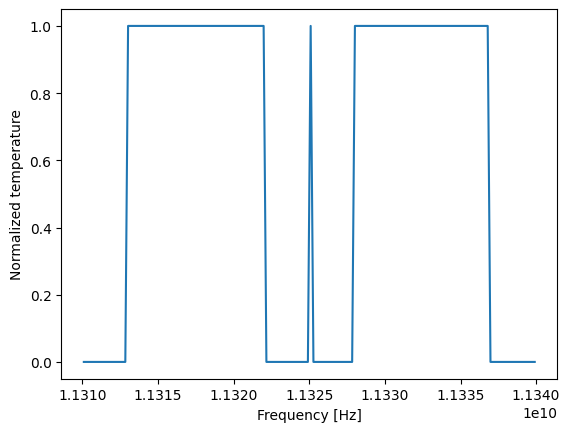

In [26]:
# new satellite transmission model that depends on frequency
tmt_profile = np.ones(new_freq_chan)
tmt_profile[:new_freq_chan//10] = 0.0
tmt_profile[-new_freq_chan//10:] = 0.0
tmt_profile[new_freq_chan//2 - new_freq_chan//10:new_freq_chan//2 + new_freq_chan//10] = 0.0
tmt_profile[new_freq_chan//2] = 1.0

freq_bins = westford_freqs.get_center_freq_chans()
def transmit_temp_freqs(tim, freq):
    ind_freq = np.argmin(np.abs(freq_bins - freq))
    return tmt_profile[ind_freq] * power_to_temperature(10**(transmit_pow/10), 1.0)  # in K

plt.figure()
plt.plot(freq_bins, tmt_profile)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized temperature")
plt.show()

The rest of the code is run the same way it was before:

In [27]:
# create transmitter instrument
sat_transmit_freqs = Instrument(sat_ant, sat_T_phy, sat_freq, sat_bw, transmit_temp_freqs, new_freq_chan, [])

starlink_constellation_freqs = Constellation.from_file(
    file_traj_sats_path, observ_freqs, sat_transmit_freqs,
    sat_link_budget_vectorized,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(filt_name, filt_el)
)

In [28]:
result_freqs = model_observed_temp(observ_freqs, sky_mdl, starlink_constellation_freqs)

In [29]:
time_samples = observ_freqs.get_time_stamps()
freq_bins = westford_freqs.get_center_freq_chans()
plot_psd = temperature_to_power(result_freqs, bw/freq_chan)
plot_pow = temperature_to_power(result[:, 0, 0], bw)

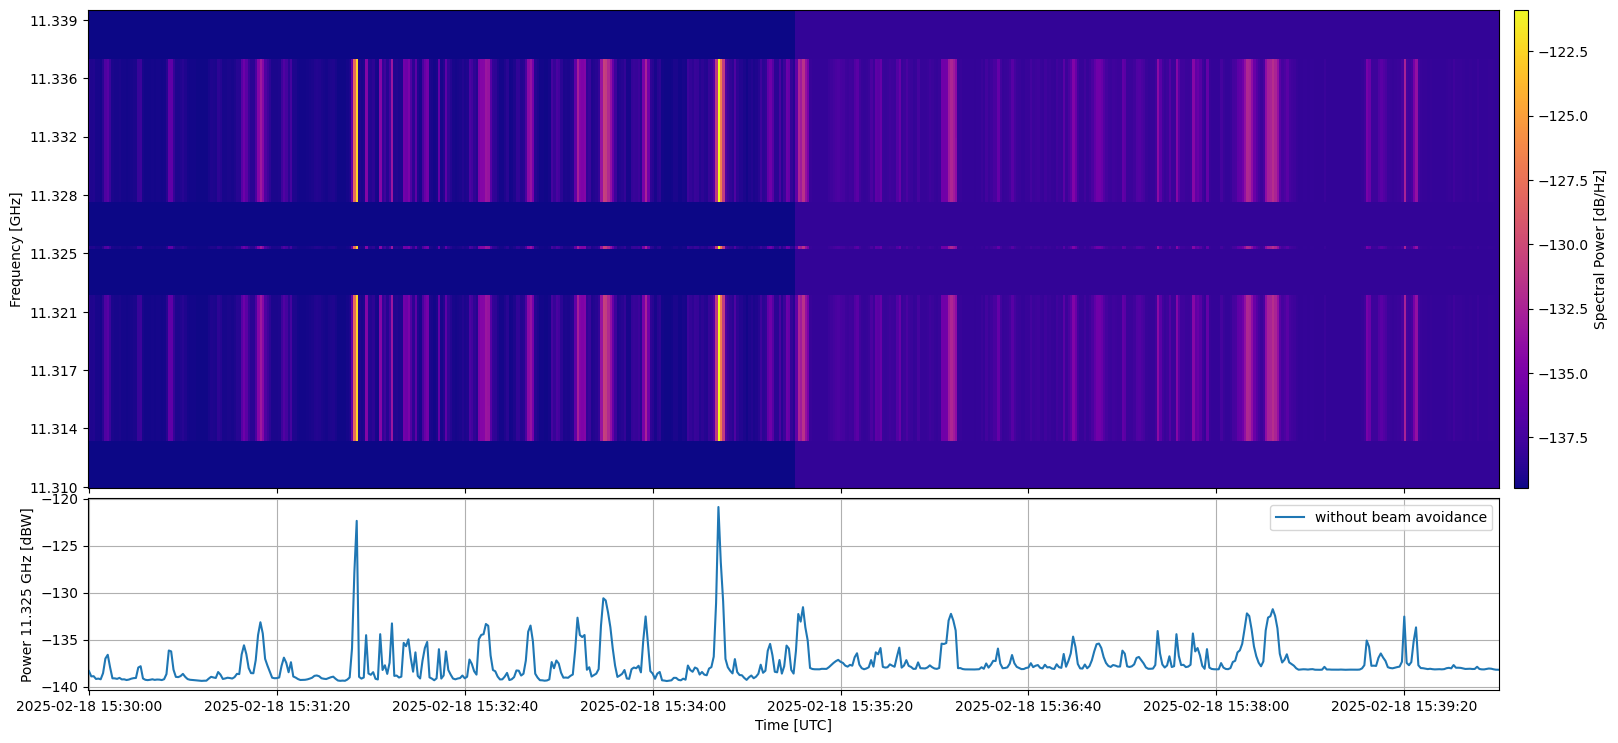

In [30]:
# plot
fig = plt.figure(figsize=(16,8))
gs = plt.matplotlib.gridspec.GridSpec(2, 2, height_ratios=[1,0.4],
                                      width_ratios=[1,0.01])
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)

ax1 = plt.subplot(gs[0,0])
psd = ax1.imshow(10 * np.log10(plot_psd[:, 0, :].T), interpolation="nearest",
                 cmap="plasma", aspect="auto")

ax1.set_xlim(-0.5, plot_psd.shape[0] - 0.5)
ax1.set_ylim(-0.5, plot_psd.shape[2] - 0.5)
ax1.set_xlabel("")
ax1.set_xticks(range(plot_psd.shape[0]))
ax1.set_xticklabels([])
ax1.xaxis.set_major_locator(plt.matplotlib.ticker.MaxNLocator(integer=True))
ax1.set_yticks(range(plot_psd.shape[2]))
ax1.set_yticklabels([f"{f/1e9:.3f}" for f in freq_bins])
ax1.yaxis.set_major_locator(plt.matplotlib.ticker.MaxNLocator(integer=True))
ax1.set_ylabel("Frequency [GHz]")

cbax = plt.subplot(gs[0,1])
cb = plt.matplotlib.colorbar.Colorbar(ax=cbax, mappable=psd)
cb.set_label("Spectral Power [dB/Hz]")

ax2 = plt.subplot(gs[1,0])
ax2.plot(range(len(time_samples)), 10 * np.log10(plot_pow), label="without beam avoidance")

ax2.set_xlim(-0.5, plot_psd.shape[0] - 0.5)
ax2.set_xticks(range(plot_psd.shape[0]))
ax2.set_xticklabels(time_samples)
ax2.xaxis.set_major_locator(plt.matplotlib.ticker.MaxNLocator(integer=True))
ax2.set_xlabel("Time [UTC]")
ax2.set_ylabel("Power 11.325 GHz [dBW]")
ax2.grid(True)
ax2.legend()

plt.show()

## Model total power over entire sky
---

The package also allows modeling the power received at each time samples for
multiple positions over the sky.

It is possible to define a `Trajectory` that points at the full sky over each
time samples:

In [31]:
# sky map
azimuth_grid = np.arange(0, 356, 5)
elevation_grid = np.arange(0, 91, 1)
time_samples = observ.get_time_stamps()

points_data = []
for t in time_samples:
    az_list = []
    el_list = []
    dist_list = []
    for az in azimuth_grid:
        for el in elevation_grid:
            az_list.append(az)
            el_list.append(el)
            dist_list.append(np.inf)
    points_data.append({
        'times': t,
        'azimuths': az_list,
        'elevations': el_list,
        'distances': dist_list
    })

points_df = pd.DataFrame(points_data)
traj_sky = Trajectory(points_df)

The simulation with satellites gives:

In [32]:
# --- Efficient sky map modeling for a single time_plot ---
# Only compute for the specific time_plot
time_plot = datetime.strptime("2025-02-18T15:34:29.000", dateformat)

# Define your azimuth/elevation grid
azimuth_grid = np.arange(0, 356, 5)
elevation_grid = np.arange(0, 91, 1)
n_az = len(azimuth_grid)
n_el = len(elevation_grid)

# Prepare output array for the case WITH satellites
map_grid = np.zeros((n_el, n_az))

# Loop over the grid for the case WITH satellites
for i, el in enumerate(elevation_grid):
    for j, az in enumerate(azimuth_grid):
        point_df = pd.DataFrame({
            'times': [time_plot],
            'azimuths': [az],
            'elevations': [el],
            'distances': [np.inf]
        })
        traj = Trajectory(point_df)
        obs = Observation.from_dates(time_plot, time_plot, traj, westford)
        result = model_observed_temp(obs, sky_mdl, starlink_constellation)
        map_grid[i, j] = result[0, 0, 0]

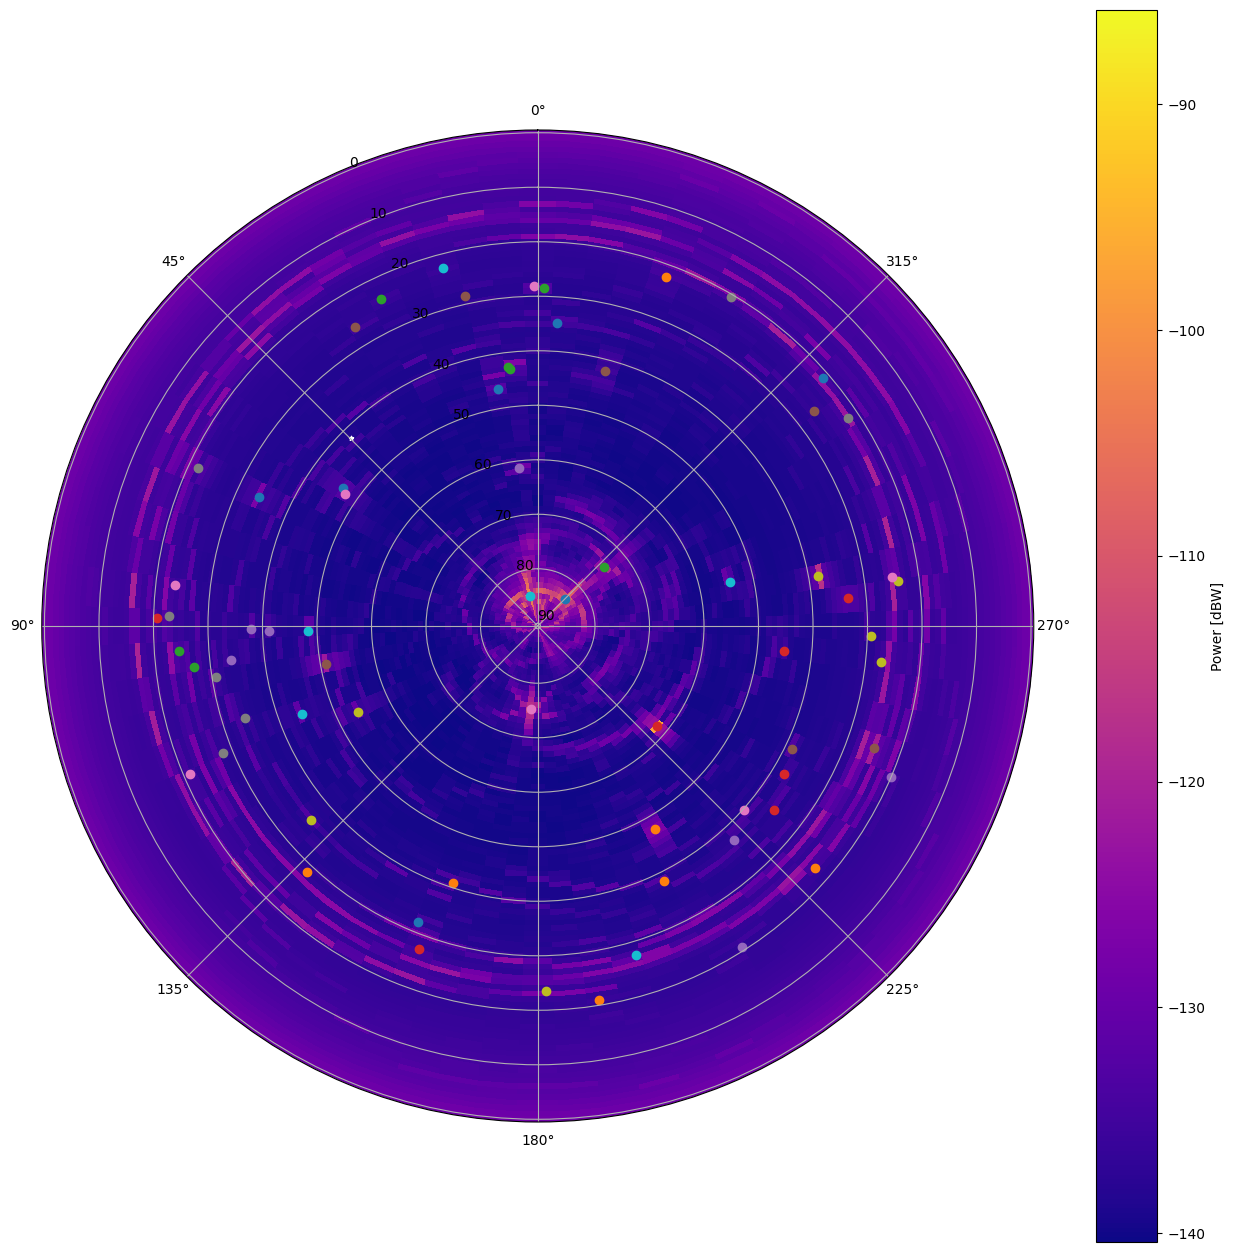

In [33]:
# Plotting for the case WITH satellites
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, polar=True)
pc = ax.pcolormesh(
    np.radians(azimuth_grid),
    90 - elevation_grid,
    10 * np.log10(temperature_to_power(map_grid, bw)),
    cmap="plasma"
)
cbar = plt.colorbar(pc)
cbar.set_label("Power [dBW]")
# Optionally, plot satellite and source positions as before
sats_at_t = starlink_constellation.get_sats_names_at_time(time_plot)
sel_sats = sats_at_t[:len(sats_at_t)]
for s in sel_sats:
    sat = starlink_constellation.get_sat_traj(s)
    sat_pt = sat[sat['times'] == time_plot]
    ax.scatter(np.radians(sat_pt['azimuths']), 90 - sat_pt['elevations'])
src_pt = traj_src.get_traj()[traj_src.get_traj()['times'] == time_plot]
ax.scatter(np.radians(src_pt['azimuths']), 90 - src_pt['elevations'],
           marker="*", c="white", s=10)
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.set_theta_zero_location("N")
plt.show()

And without accounting for satellites:

In [34]:
# Prepare output array for the case WITHOUT satellites
map_grid_no_sat = np.zeros((n_el, n_az))

# computing map_grid_no_sat
for i, el in enumerate(elevation_grid):
    for j, az in enumerate(azimuth_grid):
        point_df = pd.DataFrame({
            'times': [time_plot],
            'azimuths': [az],
            'elevations': [el],
            'distances': [np.inf]
        })
        traj = Trajectory(point_df)
        obs = Observation.from_dates(time_plot, time_plot, traj, westford)
        result = model_observed_temp(obs, sky_mdl)
        map_grid_no_sat[i, j] = result[0, 0, 0]

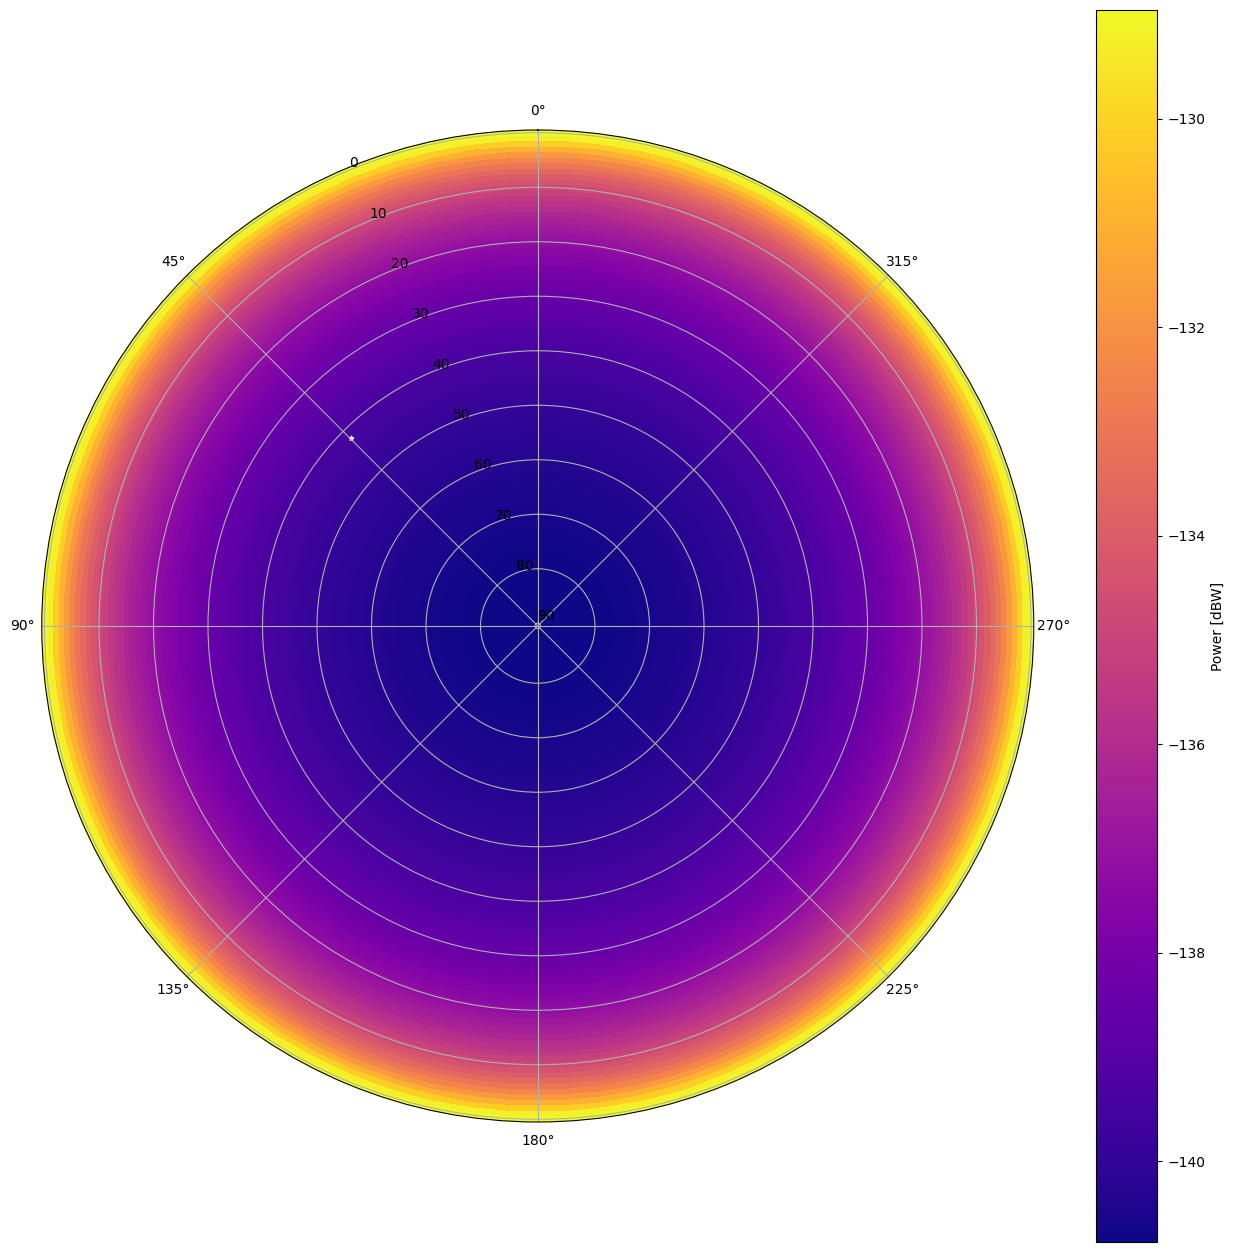

In [35]:
# Plotting for the case WITHOUT satellites
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, polar=True)
pc = ax.pcolormesh(
    np.radians(azimuth_grid),
    90 - elevation_grid,
    10 * np.log10(temperature_to_power(map_grid_no_sat, bw)), cmap="plasma"
)
cbar = plt.colorbar(pc)
cbar.set_label("Power [dBW]")
src_pt = traj_src.get_traj()[traj_src.get_traj()['times'] == time_plot]
ax.scatter(np.radians(src_pt['azimuths']), 90 - src_pt['elevations'],
           marker="*", c="white", s=10)
ax.set_yticks(range(0, 91, 10))
ax.set_yticklabels([str(x) for x in range(90, -1, -10)])
ax.set_theta_zero_location("N")
plt.show()